In [1]:
pwd

'/Users/mar/Desktop/dog-breed-classifier/notebooks'

In [4]:
print(os.listdir('../data/'))         # Affiche les dossiers/fichiers du dossier courant
print(os.listdir('../data/images'))  # Liste des dossiers races

['.DS_Store', 'Images']
['n02090622-borzoi', 'n02113023-Pembroke', 'n02113799-standard_poodle', 'n02089973-English_foxhound', 'n02085782-Japanese_spaniel', '.DS_Store', 'n02086079-Pekinese', 'n02113978-Mexican_hairless', 'n02115913-dhole', 'n02085936-Maltese_dog', 'n02086646-Blenheim_spaniel', 'n02088238-basset', 'n02085620-Chihuahua', 'n02090379-redbone', 'n02090721-Irish_wolfhound', 'n02088632-bluetick', 'n02113712-miniature_poodle', 'n02113186-Cardigan', 'n02086910-papillon', 'n02112137-chow', 'n02087394-Rhodesian_ridgeback', 'n02086240-Shih-Tzu', 'n02087046-toy_terrier', 'n02116738-African_hunting_dog', 'n02111277-Newfoundland', 'n02089867-Walker_hound', 'n02088364-beagle', 'n02111889-Samoyed', 'n02088466-bloodhound', 'n02112350-keeshond', 'n02113624-toy_poodle', 'n02111500-Great_Pyrenees', 'n02088094-Afghan_hound', 'n02115641-dingo', 'n02112018-Pomeranian', 'n02112706-Brabancon_griffon', 'n02089078-black-and-tan_coonhound']


In [3]:
import os
import numpy as np
from PIL import Image

def load_dog_breed_dataset(data_dir, image_size=(128, 128)):
    """
    Charge les images depuis un dossier organisé par classe, et crée arrays d'images et labels.
    
    Args:
        data_dir (str): chemin vers le dossier racine du dataset (ex: "data/image")
        image_size (tuple): taille à redimensionner pour chaque image (largeur, hauteur)
    
    Returns:
        images (np.array): tableau numpy de toutes les images redimensionnées (N, H, W, C)
        labels (np.array): tableau numpy des labels (entiers)
        class_names (list): liste des noms des classes (ordre indexé selon labels)
    """
    images = []
    labels = []
    class_names = []
    class_to_idx = {}

    # On récupère tous les dossiers (une race par dossier)
    breed_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    breed_folders.sort()  # pour avoir un ordre stable

    for idx, breed in enumerate(breed_folders):
        # On extrait uniquement le nom après le tiret
        breed_name = breed.split("-")[-1]
        class_to_idx[breed] = idx
        class_names.append(breed_name)

        breed_path = os.path.join(data_dir, breed)
        for img_file in os.listdir(breed_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(breed_path, img_file)
                images.append(img_path)
                labels.append(idx)

    images = np.array(images)
    labels = np.array(labels)
    print(f"Chargé {len(images)} images pour {len(class_names)} classes.")

    return images, labels, class_names


# Exemple d'utilisation
if __name__ == "__main__":
    data_dir = "../data/Images"
    images, labels, class_names = load_dog_breed_dataset(data_dir)


Chargé 6416 images pour 36 classes.


In [5]:
class_names

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Newfoundland',
 'Great_Pyrenees',
 'Samoyed',
 'Pomeranian',
 'chow',
 'keeshond',
 'Brabancon_griffon',
 'Pembroke',
 'Cardigan',
 'toy_poodle',
 'miniature_poodle',
 'standard_poodle',
 'Mexican_hairless',
 'dingo',
 'dhole',
 'African_hunting_dog']

In [6]:
chihuahua_index = class_names.index("Chihuahua")
nb_chihuahua = sum(label == chihuahua_index for label in labels)

print(f"Nombre d'images de Chihuahua : {nb_chihuahua}")

Nombre d'images de Chihuahua : 152


In [7]:
# makedataset.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
import random

2025-07-28 22:42:01.592636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:

def visualize_class_distribution(y, class_names=None):
    class_counts = Counter(y)
    keys = sorted(class_counts.keys())
    values = [class_counts[k] for k in keys]

    if class_names and max(keys) < len(class_names):
        tick_labels = [class_names[k] for k in keys]
    else:
        tick_labels = [str(k) for k in keys]

    plt.figure(figsize=(12, 6))
    plt.bar(keys, values, tick_label=tick_labels)
    plt.xticks(rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    plt.title('Distribution des classes')
    plt.show()

In [9]:

def plot_images_from_subfolders(base_dir, num_images=3):
    subfolders = [
        os.path.join(base_dir, folder)
        for folder in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, folder))
    ]

    for folder_path in subfolders:
        relative_path = os.path.relpath(folder_path, base_dir)
        class_name = relative_path.split('-')[-1]
        print(f"Images de: {class_name}")
        _, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
        files = os.listdir(folder_path)[:num_images]

        for i in range(len(files)):
            img_path = os.path.join(folder_path, files[i])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].axis('off')
        plt.show()


In [10]:


def img_dimensions(base_dir):
    for dir_name in os.listdir(base_dir):
        dir_path = os.path.join(base_dir, dir_name)
        if os.path.isdir(dir_path):
            print(f'Analyse des images en: {dir_path}')
            files = os.listdir(dir_path)
            dim = []

            for file_name in files:
                img_path = os.path.join(dir_path, file_name)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width, _ = img.shape
                    dim.append((height, width))

            count_dim = Counter(dim)
            print("Dimensions les plus courantes:")
            for dimension, freq in count_dim.most_common(5):
                print(f"{dimension}: {freq}")
            print('\n')



In [11]:

import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from typing import Tuple
from tqdm import tqdm

def process_dataset(source_dir, processed_dir, target_size=(128, 128)) -> Tuple[np.ndarray, np.ndarray, list]:
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    data = []
    labels = []
    class_names = []
    class_to_index = {}

    # Récupérer toutes les classes dès le début
    all_class_folders = [f for f in sorted(os.listdir(source_dir)) if os.path.isdir(os.path.join(source_dir, f))]
    
    # Extraire les vrais noms de classe (ex : 'Chihuahua') et construire le mapping
    for idx, class_folder in enumerate(all_class_folders):
        class_name = class_folder.split('-')[-1]
        class_names.append(class_name)
        class_to_index[class_name] = idx

    # Maintenant qu'on a le mapping complet, on peut charger les images
    for class_folder in tqdm(all_class_folders, desc="Processing dataset"):
        full_path = os.path.join(source_dir, class_folder)
        class_name = class_folder.split('-')[-1]
        class_index = class_to_index[class_name]

        dest_class_dir = os.path.join(processed_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)

        for img_file in os.listdir(full_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                try:
                    img_path = os.path.join(full_path, img_file)
                    image = cv2.imread(img_path)
                    image_resized = cv2.resize(image, target_size)
                    image_array = img_to_array(image_resized)
                    data.append(image_array)
                    labels.append(class_index)

                    save_path = os.path.join(dest_class_dir, img_file)
                    cv2.imwrite(save_path, image_resized)
                except Exception as e:
                    print(f"Erreur sur {img_file}: {e}")

    data = np.array(data, dtype="float32") / 255.0
    labels = to_categorical(np.array(labels), num_classes=len(class_names))  # ✅ fixer le nombre de classes

    return data, labels, class_names



In [12]:
RAW_DIR = "../data/Images"
PROCESSED_DIR = "data/processed"
images, labels, class_names = process_dataset(RAW_DIR, PROCESSED_DIR)

Processing dataset: 100%|███████████████████████| 36/36 [00:14<00:00,  2.45it/s]


In [13]:
len(images)
images.shape

(6416, 128, 128, 3)

In [14]:
class_names

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'tan_coonhound',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Newfoundland',
 'Great_Pyrenees',
 'Samoyed',
 'Pomeranian',
 'chow',
 'keeshond',
 'Brabancon_griffon',
 'Pembroke',
 'Cardigan',
 'toy_poodle',
 'miniature_poodle',
 'standard_poodle',
 'Mexican_hairless',
 'dingo',
 'dhole',
 'African_hunting_dog']

In [15]:
print("Nombre de classes :", labels.shape[1])
print("Exemple de labels (one-hot) :", labels[29])
labels[151]

Nombre de classes : 36
Exemple de labels (one-hot) : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [16]:

chihuahua_index = class_names.index("Chihuahua")

# Compte combien de labels correspondent à cet index
nb_chihuahua = sum(np.argmax(label) == chihuahua_index for label in labels)

print(f"Nombre d'images de Chihuahua : {nb_chihuahua}")

Nombre d'images de Chihuahua : 152


In [37]:
data, labels, class_names = process_dataset(
    "/Users/mar/Desktop/dog-breed-classifier/data/Images",
    "/Users/mar/Desktop/dog-breed-classifier/processed"
)


Processing dataset: 100%|███████████████████████| 36/36 [00:14<00:00,  2.41it/s]


In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import LabelEncoder

# Aplatir les images
X = data.reshape((data.shape[0], -1))

# Transformer les labels one-hot en entiers
y = np.argmax(labels, axis=1)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lancer LazyPredict
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Afficher les résultats
print(models.head(10))

  0%|          | 0/31 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.07476635514018691, 'Balanced Accuracy': 0.06909544732528611, 'ROC AUC': None, 'F1 Score': 0.060103769044645955, 'Time taken': 903.8462660312653}


In [ ]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lazypredict.Supervised import LazyClassifier

from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

def process_dataset(source_dir, target_size=(128, 128)):
    data = []
    labels = []
    class_names = []
    class_to_index = {}

    all_class_folders = [f for f in sorted(os.listdir(source_dir)) if os.path.isdir(os.path.join(source_dir, f)) and not f.startswith(".")]

    for idx, class_folder in enumerate(all_class_folders):
        class_name = class_folder.split('-')[-1]
        class_names.append(class_name)
        class_to_index[class_name] = idx

    for class_folder in tqdm(all_class_folders, desc="Chargement images"):
        full_path = os.path.join(source_dir, class_folder)
        class_name = class_folder.split('-')[-1]
        class_index = class_to_index[class_name]

        for img_file in os.listdir(full_path):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                try:
                    img_path = os.path.join(full_path, img_file)
                    image = cv2.imread(img_path)
                    image_resized = cv2.resize(image, target_size)
                    image_array = img_to_array(image_resized)
                    data.append(image_array)
                    labels.append(class_index)
                except:
                    continue

    data = np.array(data, dtype="float32") / 255.0
    labels = np.array(labels)

    return data, labels, class_names

# Remplace ce chemin par le tien
source_dir = "/Users/mar/Desktop/dog-breed-classifier/data/Images"
data, labels, class_names = process_dataset(source_dir)

# Augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_data = []
augmented_labels = []

for i in tqdm(range(len(data)), desc="Génération d'images augmentées"):
    x = data[i].reshape((1,) + data[i].shape)
    label = labels[i]
    count = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_data.append(batch[0])
        augmented_labels.append(label)
        count += 2  
        if count >= 2:
            break

X_full = np.concatenate([data] + [np.array(augmented_data)])
y_full = np.concatenate([labels] + [np.array(augmented_labels)])

print(f"✅ Total images après augmentation : {X_full.shape[0]}")

# lazyPredict
print("Test des modèles avec LazyPredict...")

# Aplatir les images (pour LazyPredict)
X_flat = X_full.reshape((X_full.shape[0], -1))

# Encodage (pas besoin de one-hot pour LazyPredict)
le = LabelEncoder()
y_encoded = le.fit_transform(y_full)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_encoded, test_size=0.2, random_state=42)

# Lancer LazyClassifier
clf = LazyClassifier(verbose=1, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Affichage des résultats
print(models.head(10))


Génération d'images augmentées: 100%|██████| 6416/6416 [00:30<00:00, 211.94it/s]


✅ Total images après augmentation : 12832
Test des modèles avec LazyPredict...


  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
def split_data(data, labels, val_size=0.2, test_size=0.2, random_state=42):
    x_train_val, x_test, y_train_val, y_test = train_test_split(
        data, labels, test_size=test_size, random_state=random_state
    )
    val_size_adj = val_size / (1 - test_size)
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_val, y_train_val, test_size=val_size_adj, random_state=random_state
    )
    return x_train, x_val, x_test, y_train, y_val, y_test


def check_class_distribution(y_data, classes):
    y_indices = np.argmax(y_data, axis=1)
    return {classes[i]: np.sum(y_indices == i) for i in range(len(classes))}

In [14]:
# Découpage
x_train, x_val, x_test, y_train, y_val, y_test = split_data(images, labels)

print("Répartition train :", check_class_distribution(y_train, class_names))
print("Répartition val :", check_class_distribution(y_val, class_names))
print("Répartition test :", check_class_distribution(y_test, class_names))

Répartition train : {'Chihuahua': 83, 'Japanese_spaniel': 116, 'Maltese_dog': 146, 'Pekinese': 92, 'Tzu': 136, 'Blenheim_spaniel': 101, 'papillon': 121, 'toy_terrier': 100, 'Rhodesian_ridgeback': 110, 'Afghan_hound': 129, 'basset': 110, 'beagle': 130, 'bloodhound': 107, 'bluetick': 108, 'tan_coonhound': 98, 'Walker_hound': 89, 'English_foxhound': 99, 'redbone': 89, 'borzoi': 80, 'Irish_wolfhound': 134, 'Newfoundland': 108, 'Great_Pyrenees': 127, 'Samoyed': 120, 'Pomeranian': 134, 'chow': 110, 'keeshond': 96, 'Brabancon_griffon': 92, 'Pembroke': 108, 'Cardigan': 99, 'toy_poodle': 92, 'miniature_poodle': 102, 'standard_poodle': 97, 'Mexican_hairless': 93, 'dingo': 98, 'dhole': 84, 'African_hunting_dog': 111}
Répartition val : {'Chihuahua': 30, 'Japanese_spaniel': 24, 'Maltese_dog': 47, 'Pekinese': 30, 'Tzu': 43, 'Blenheim_spaniel': 48, 'papillon': 33, 'toy_terrier': 33, 'Rhodesian_ridgeback': 25, 'Afghan_hound': 59, 'basset': 34, 'beagle': 29, 'bloodhound': 45, 'bluetick': 26, 'tan_coonh

Analyse des images en: ../data/Images/n02113712-miniature_poodle
Dimensions les plus courantes:
(375, 500): 35
(333, 500): 13
(500, 375): 13
(500, 333): 6
(500, 500): 3


Analyse des images en: ../data/Images/n02089973-English_foxhound
Dimensions les plus courantes:
(375, 500): 7
(150, 120): 2
(358, 500): 2
(384, 512): 2
(240, 320): 2


Analyse des images en: ../data/Images/n02115913-dhole
Dimensions les plus courantes:
(333, 500): 30
(375, 500): 23
(374, 500): 5
(300, 460): 5
(253, 381): 5


Analyse des images en: ../data/Images/n02090379-redbone
Dimensions les plus courantes:
(375, 500): 50
(333, 500): 29
(500, 375): 20
(500, 333): 5
(357, 500): 2


Analyse des images en: ../data/Images/n02085782-Japanese_spaniel
Dimensions les plus courantes:
(449, 600): 9
(375, 500): 5
(480, 640): 4
(150, 200): 4
(200, 200): 3


Analyse des images en: ../data/Images/n02088632-bluetick
Dimensions les plus courantes:
(375, 500): 47
(333, 500): 15
(500, 375): 6
(335, 500): 4
(500, 333): 4


Analyse de

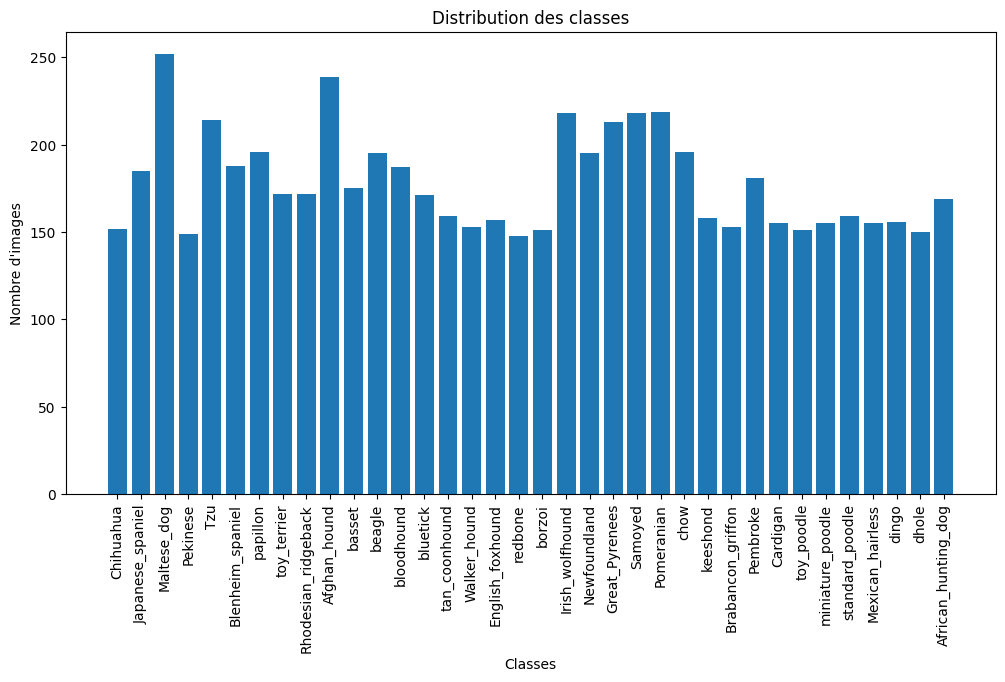

In [15]:
# Vérifier quelques images brutes
# plot_images_from_subfolders(RAW_DIR)
img_dimensions(RAW_DIR)


# Visualiser la distribution
visualize_class_distribution(np.argmax(labels, axis=1), class_names)

In [18]:
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Séparation des données
def split_data(data, labels, val_size=0.2, test_size=0.2, random_state=42):
    # Supposer que labels est déjà encodé en one-hot
    x_temp, x_test, y_temp, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=val_size, random_state=random_state)
    return x_train, x_val, x_test, y_train, y_val, y_test

# 2. Définition du modèle CNN
def create_model(input_shape, num_classes, sparse_labels=False):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    loss_fn = 'sparse_categorical_crossentropy' if sparse_labels else 'categorical_crossentropy'
    
    model.compile(
        optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy']
    )
    
    return model

# 3. Entraînement du modèle avec MLflow
def train_model_with_mlflow(x_train, y_train, x_val, y_val, input_shape, num_classes, sparse_labels=False, experiment_name="image_classification"):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        model = create_model(input_shape, num_classes, sparse_labels=sparse_labels)
        
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("epochs", 10)
        mlflow.log_param("batch_size", 32)
        
        history = model.fit(
            x_train, y_train,
            epochs=10,
            batch_size=32,
            validation_data=(x_val, y_val),
            verbose=2
        )
        
        final_val_acc = history.history["val_accuracy"][-1]
        mlflow.log_metric("val_accuracy", final_val_acc)
        mlflow.keras.log_model(model, "model")
        
        return model

# 4. Évaluation du modèle
def evaluate_model(model, x_test, y_test, class_names=None):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test accuracy: {test_accuracy:.4f}")
    return test_accuracy

# 5. Sauvegarde du modèle
def save_model_as_h5(model, path="best_model.h5"):
    model.save(path)
    print(f"✅ Modèle sauvegardé à {path}")


In [20]:
# Découpage
x_train, x_val, x_test, y_train, y_val, y_test = split_data(images, labels)


# 3. Déterminer les dimensions pour créer le modèle
input_shape = x_train.shape[1:]              # (hauteur, largeur, canaux)
num_classes = y_train.shape[1]        # nombre de races différentes

# 4. Entraîner le modèle (MLflow s’enregistre tout seul dans la fonction)
model = train_model_with_mlflow(
    x_train, y_train,
    x_val, y_val,
    input_shape=input_shape,
    num_classes=num_classes
)

# 5. Sauvegarder le modèle pour réutilisation future
save_model_as_h5(model)

# 6. Évaluer sur le test set
class_names = [str(i) for i in range(num_classes)]
evaluate_model(model, x_test, y_test, class_names)

Epoch 1/10


2025-07-28 17:13:06.994502: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 807075840 exceeds 10% of free system memory.


129/129 - 31s - 240ms/step - accuracy: 0.0370 - loss: 3.6537 - val_accuracy: 0.0623 - val_loss: 3.5344
Epoch 2/10
129/129 - 28s - 219ms/step - accuracy: 0.1006 - loss: 3.3524 - val_accuracy: 0.0954 - val_loss: 3.3517
Epoch 3/10
129/129 - 28s - 219ms/step - accuracy: 0.2697 - loss: 2.6841 - val_accuracy: 0.1305 - val_loss: 3.3823
Epoch 4/10
129/129 - 28s - 220ms/step - accuracy: 0.6146 - loss: 1.4426 - val_accuracy: 0.1422 - val_loss: 4.2261
Epoch 5/10
129/129 - 28s - 216ms/step - accuracy: 0.8838 - loss: 0.4579 - val_accuracy: 0.1246 - val_loss: 5.6149
Epoch 6/10
129/129 - 28s - 214ms/step - accuracy: 0.9754 - loss: 0.1366 - val_accuracy: 0.1285 - val_loss: 6.9537
Epoch 7/10
129/129 - 28s - 215ms/step - accuracy: 0.9915 - loss: 0.0584 - val_accuracy: 0.1227 - val_loss: 7.9988
Epoch 8/10
129/129 - 28s - 220ms/step - accuracy: 0.9971 - loss: 0.0316 - val_accuracy: 0.1392 - val_loss: 8.0201
Epoch 9/10
129/129 - 29s - 222ms/step - accuracy: 0.9983 - loss: 0.0267 - val_accuracy: 0.1412 - va

2025/07/28 17:17:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/28 17:17:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/07/28 17:18:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Modèle sauvegardé à best_model.h5
41/41 - 2s - 44ms/step - accuracy: 0.1168 - loss: 8.3943
Test accuracy: 0.1168


0.11682242900133133

In [4]:
"""
Module for loading and preprocessing data for dog breed classification
"""

import os
import random
from collections import Counter
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tqdm import tqdm


def load_data(path: str, target_size=(128, 128)) -> tuple:
    images = []
    labels = []
    class_names = []
    labels_ = {}
    current_label = 0

    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            if class_name not in labels_:
                labels_[class_name] = current_label
                class_names.append(class_name)
                current_label += 1
            for img_name in tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    try:
                        # Redimensionnement uniforme ici
                        img = cv2.resize(img, target_size)
                        images.append(img)
                        labels.append(labels_[class_name])
                    except Exception as e:
                        print(f"[SKIPPED] {img_path} — erreur resize : {e}")
                        continue

    return np.array(images, dtype="float32"), np.array(labels), class_names



def visualize_class_distribution(labels: np.ndarray, class_names: list):
    class_counts = Counter(labels)
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title('Distribution des classes')
    plt.show()


def plot_images_from_subfolders(base_dir, num_images=3):
    subfolders = [
        os.path.join(base_dir, folder)
        for folder in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, folder))
    ]
    for folder_path in subfolders:
        relative_path = os.path.relpath(folder_path, base_dir)
        print(f"Images de: {relative_path}")
        _, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
        files = os.listdir(folder_path)
        for i in range(num_images):
            img_path = os.path.join(folder_path, files[i])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].axis('off')
        plt.show()


def img_dimensions(base_dir):
    for dir_name in os.listdir(base_dir):
        dir_path = os.path.join(base_dir, dir_name)
        if os.path.isdir(dir_path):
            print(f'Analyse des images en: {dir_path}')
            files = os.listdir(dir_path)
            dim = []
            for file_name in files:
                img_path = os.path.join(dir_path, file_name)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width, _ = img.shape
                    dim.append((height, width))
            count_dim = Counter(dim)
            print("Dimensions les plus courantes:")
            for dimension, freq in count_dim.most_common(15):
                print(f"Dimension: {dimension}, Fréquence: {freq}")
            print('\n')


def process_dataset(source_dir, processed_dir):
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    data = []
    labels = []

    random.seed(42)

    for class_name in sorted(os.listdir(source_dir)):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        def process_and_save_files(file_list, dest_dir):
            class_dest_dir = os.path.join(dest_dir, class_name)
            os.makedirs(class_dest_dir, exist_ok=True)
            for file in file_list:
                try:
                    image_path = os.path.join(class_dir, file)
                    image = cv2.imread(image_path)
                    image_resized = cv2.resize(image, (128, 128))
                    image_array = img_to_array(image_resized)
                    data.append(image_array)
                    labels.append(class_name)
                    save_path = os.path.join(class_dest_dir, file)
                    cv2.imwrite(save_path, image_resized)
                except Exception as e:
                    print(f"Erreur avec {file}: {e}")
                    continue

        process_and_save_files(files, processed_dir)
        print(f"Classe {class_name}: {len(files)} traitées")

    return np.array(data, dtype="float32"), np.array(labels)


def increase_dataset(data, labels, zoom_range=0.2, horizontal_flip=True, augmentation_ratio=1/3):
    datagen = ImageDataGenerator(
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip
    )

    augmented_images = []
    augmented_labels = []

    augmentation_count = int(len(data) * augmentation_ratio)

    for img, label in zip(data, labels):
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0].astype('uint8'))
            augmented_labels.append(label)
            i += 1
            if i >= (augmentation_count / len(data)):
                break

    final_imgs_data = np.concatenate((data, augmented_images), axis=0)
    final_labels_data = np.concatenate((labels, augmented_labels), axis=0)

    return final_imgs_data, final_labels_data


def split_data(data, labels, val_size=0.2, test_size=0.2, random_state=42):
    x_train_val, x_test, y_train_val, y_test = train_test_split(
        data,
        labels,
        test_size=test_size,
        random_state=random_state
    )
    val_size_adj = val_size / (1 - test_size)
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_val,
        y_train_val,
        test_size=val_size_adj,
        random_state=random_state
    )
    return x_train, x_val, x_test, y_train, y_val, y_test


def check_class_distribution(y_data, classes):
    return {cls: np.sum(np.argmax(y_data, axis=1) == cls) for cls in classes}


Loading n02112137-chow: 100%|███████████████| 196/196 [00:00<00:00, 1021.16it/s]
Loading n02087394-Rhodesian_ridgeback: 100%|█| 172/172 [00:00<00:00, 1042.45it/s
Loading n02112706-Brabancon_griffon: 100%|███| 153/153 [00:00<00:00, 994.84it/s]
Loading n02089078-black-and-tan_coonhound: 100%|█| 159/159 [00:00<00:00, 1215.52


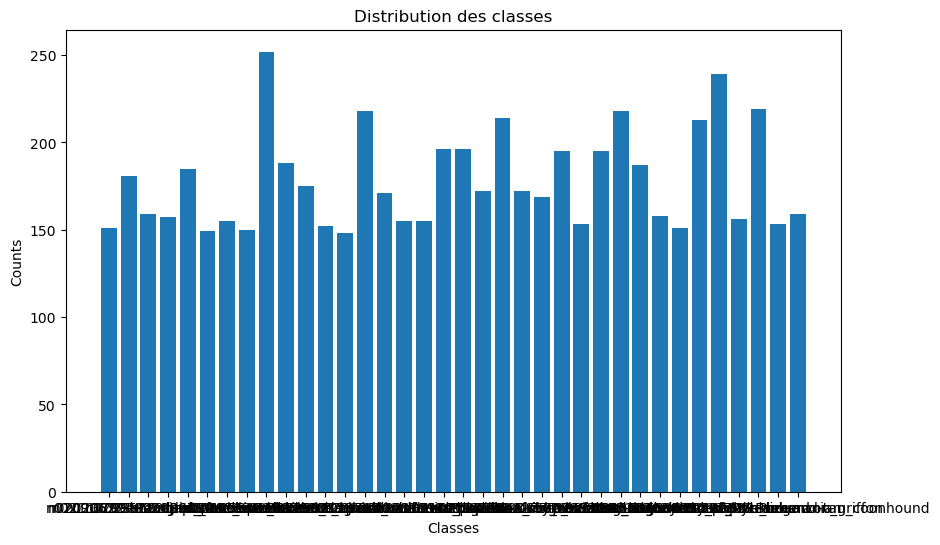

In [5]:
images, labels, class_names = load_data("../data/images")
visualize_class_distribution(labels, class_names)